In [1]:
import pandas as pd
import numpy as np
import warnings 
from sklearn.preprocessing import Imputer,StandardScaler,LabelEncoder,PolynomialFeatures,MinMaxScaler,OneHotEncoder,RobustScaler
from sklearn.linear_model import LinearRegression,SGDRegressor,Lasso,ElasticNet,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from matplotlib import pyplot
import seaborn as sns
import pickle
from sklearn.svm import LinearSVR,SVR
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,ShuffleSplit,train_test_split,cross_val_predict,cross_validate
from sklearn.feature_selection import RFECV,SelectKBest
from scipy.stats import normaltest,skew,skewtest,boxcox,probplot
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from mlxtend.regressor import StackingRegressor
from featexp import get_trend_stats,get_univariate_plots
import xgboost as xgb
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import re
%pylab inline
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
    
def make_submission(preds):
    sample = pd.read_csv('sample_submission.csv')
    sample['SalePrice'] = preds
    sample.to_csv('submission.csv',index=False)
    
def rmsle_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)



Populating the interactive namespace from numpy and matplotlib


## Data preparation

After several tries and with regard to some other kernels I decided to get rid of most significant outliers, fix skewness of some variables, add a little bit of my own and do a heavy grid search on a large set of models to find the best options.

From other kernels (especially https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) it is clear, that we are dealing with some kind of linear relationship between independant variables and target (at least, the most important ones are with no doubt in this kind of linearship), but I won't limit myself with linear models only. One of the purposes of this kernel is to get some practical experience with different models and to get a "feel" of what could fit and what couldn't. So let's do it!

In [12]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.drop("Id",1,inplace=True)
test_df.drop("Id",1,inplace=True)

#Outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#
y_train = train_df.SalePrice.values
train_df.drop('SalePrice',axis=1,inplace=True)

with open('features_dict','rb') as f:
    features_dict = pickle.load(f)
    
idx_split = train_df.shape[0]
full_df = pd.concat((train_df,test_df))




In [13]:
#Missing values percentage
isna_df = (full_df.isnull().sum() / full_df.shape[0] * 100).sort_values(ascending=False)
isna_df = pd.DataFrame(data = isna_df[isna_df.values != 0].values,columns=['Missing Ratio'],index=isna_df[isna_df.values != 0].index)
isna_df.head()

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151


### Fixing some missing values

In [14]:
#Feature replacement (data description says NA = No such feature in house)
full_df['PoolQC'] = full_df['PoolQC'].fillna("None")
full_df['MiscFeature'] = full_df['MiscFeature'].fillna("None")
full_df['Alley'] = full_df['Alley'].fillna("None")
full_df['FireplaceQu'] = full_df['FireplaceQu'].fillna("None")
full_df['Fence'] = full_df['Fence'].fillna("None")

#My guess is that Lot frontage could be a median Neighborhood frontage
full_df['LotFrontage'] = full_df.groupby("Neighborhood")['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#No value == no garage
for el in ['GarageCond', 'GarageQual','GarageFinish', 'GarageType']:
    full_df[el].fillna("None",inplace=True)

#Same thing
for el in ['GarageYrBlt', 'GarageArea','GarageCars']:
    full_df[el].fillna(0,inplace=True)

#Just filling this NaNs
for el in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    full_df[el].fillna(0,inplace=True)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full_df[col] = full_df[col].fillna('None')
    


full_df["MasVnrType"] = full_df["MasVnrType"].fillna("None")
full_df["MasVnrArea"] = full_df["MasVnrArea"].fillna(0)

full_df['MSZoning'] = full_df['MSZoning'].fillna(full_df['MSZoning'].mode()[0])
full_df.drop(['Utilities'],1,inplace=True)

#Data descryption says "Assume typical unless deductions are warranted"
full_df["Functional"] = full_df["Functional"].fillna("Typ")

#Just replace Nan with most typical
full_df['Electrical'] = full_df['Electrical'].fillna(full_df['Electrical'].mode()[0])

#Same thing
full_df['Exterior1st'] = full_df['Exterior1st'].fillna(full_df['Exterior1st'].mode()[0])
full_df['Exterior2nd'] = full_df['Exterior2nd'].fillna(full_df['Exterior2nd'].mode()[0])

full_df['KitchenQual'] = full_df['KitchenQual'].fillna(full_df['KitchenQual'].mode()[0])

full_df['MSSubClass'] = full_df['MSSubClass'].fillna("None")

full_df['SaleType'] = full_df['SaleType'].fillna(full_df['SaleType'].mode()[0])


In [15]:
#Check are there any NAn values left
(full_df.isna().sum() / full_df.shape[0]).sort_values(ascending=False).head()

SaleCondition    0.0
BsmtQual         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
dtype: float64

In [16]:
#Some numerical values are really categorical
full_df['MSSubClass'] = full_df['MSSubClass'].astype("str")
full_df['OverallCond'] = full_df['OverallCond'].astype("str")
full_df['YrSold'] = full_df['YrSold'].astype("str")
full_df['MoSold'] = full_df['MoSold'].astype("str")

cat_cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

#Encode our variables
for el in cat_cols:
    full_df[el] = LabelEncoder().fit_transform(full_df[el])
    
print(full_df.shape)
        


(2917, 78)


In [17]:
#Let's add some new variables
full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['1stFlrSF'] + full_df['2ndFlrSF']

# Numeric relations 
full_df['Year_built_decades'] = list(map(int,full_df['YearBuilt'].astype('int64') / 10))
full_df['Year_remodel_decades'] = list(map(int,full_df['YearRemodAdd'].astype('int64') / 10))
full_df['SF per above room'] = list(map(int,(full_df['GrLivArea'] / full_df['TotRmsAbvGrd'])/10))
#Binary features
full_df['IsNew'] = full_df['YearBuilt'].apply(lambda x: 1 if x >= 1995 else 0)
full_df['Remodeled_recently'] = full_df['YearRemodAdd'].apply(lambda x: 1 if x >= 1995  else 0)
full_df['Built and remodeled at once'] = (full_df['YearBuilt']  == full_df['YearRemodAdd']).apply(lambda x: 1 if x == True else 0)


In [18]:
#Fixing skewness
numeric_feats = full_df.dtypes[full_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = full_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [19]:
#Box-Cox for some reasons did better job than just log1p
from scipy.special import boxcox1p
skewed_features = skewness[abs(skewness) > 0.75].index
lmbda = 0.15
for el in skewed_features:
    full_df[el] = boxcox1p(full_df[el],lmbda)

In [20]:
#Save everything so there is no need to run this part of code again
full_df.to_csv('clean_full_df.csv',index=False)

full_df = pd.get_dummies(full_df)
train = full_df.iloc[:idx_split]
test = full_df.iloc[idx_split:]
full_df.to_csv('full_df_new_features_dummies.csv',index=False)

Finally, let's look at top-20 important features due to RandomForest

(-1, 20)

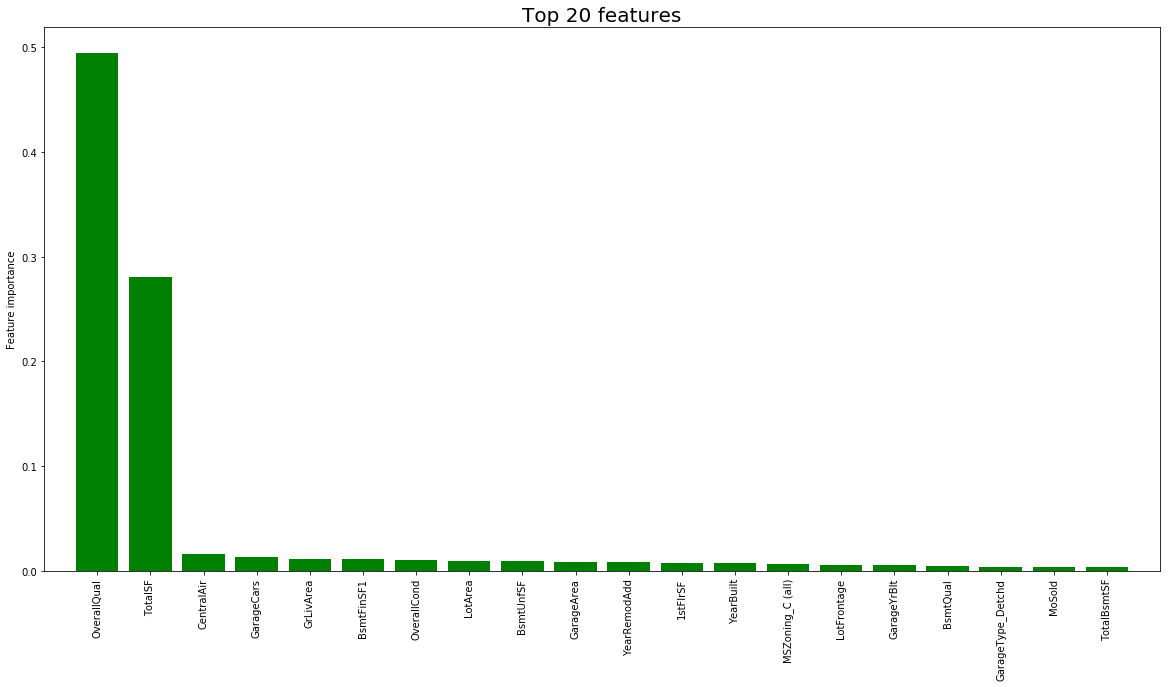

In [64]:
forest = RandomForestRegressor()
forest.fit(full_df.iloc[:idx_split],y_train)
importances = forest.feature_importances_
importance_values = sorted(importances,reverse=True)
importance_columns = full_df.columns[importances.argsort()[::-1]]

plt.figure(figsize=(20,10))
plt.title("Top 20 features",fontsize=20)
plt.bar(range(20),importance_values[:20],color='g',align="center")
plt.xticks(range(20),importance_columns[:20],rotation=90)
plt.ylabel("Feature importance")
plt.xlim([-1,20])

## Going to models

In [21]:
full_df = pd.read_csv('full_df_new_features_dummies.csv')
with open('y_train.pickle','rb') as f:
    y_train = pickle.load(f)
idx_split = 1458
train = full_df.iloc[:idx_split]
test = full_df.iloc[idx_split:]

In [65]:
#Creating a bunch of pipelines. RobustScaler did the better job than the StandardScaler, so I will use it.
pipes = [
    Pipeline([('scaler',RobustScaler()), ('regressor',Lasso(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',Ridge(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',ElasticNet(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',LinearRegression())]),
    Pipeline([('regressor',SGDRegressor(random_state = 42))]),
    Pipeline([('regressor',RandomForestRegressor(random_state = 42))]),
    Pipeline([('regressor',AdaBoostRegressor(random_state = 42))]),
    Pipeline([('regressor',GradientBoostingRegressor(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',LinearSVR(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',SVR())]),
    Pipeline([('scaler',RobustScaler()), ('regressor',KNeighborsRegressor())]),
    Pipeline([('regressor',XGBRegressor(random_state = 42))]),
    Pipeline([('regressor',lgb.LGBMRegressor(objective='regression'))]),
    Pipeline([('scaler',RobustScaler()),('regressor',KernelRidge())])
]

In [75]:
#Looking at the default models performance
arr = np.zeros(shape=(len(pipes),3),dtype='object')
for ind,pipe in enumerate(pipes):
    m = re.match("(.+)([.])([A-Za-z0-9-]+)(['>])",str(type(pipe.get_params()['regressor'])))
    score = rmsle_cv(pipe)
    arr[ind] = [m.group(3),score.mean(),score.std()]   
    print("Iter %i out of %i completed" % (ind + 1,len(pipes)))  
    

Iter 1 out of 14 completed
Iter 2 out of 14 completed
Iter 3 out of 14 completed
Iter 4 out of 14 completed
Iter 5 out of 14 completed
Iter 6 out of 14 completed
Iter 7 out of 14 completed
Iter 8 out of 14 completed
Iter 9 out of 14 completed
Iter 10 out of 14 completed
Iter 11 out of 14 completed
Iter 12 out of 14 completed
Iter 13 out of 14 completed
Iter 14 out of 14 completed


In [76]:
res_df = pd.DataFrame(index=arr[:,0],columns=['mean','std'],data=arr[:,1:])
res_df.sort_values('mean')

,mean,std
Ridge,0.118592,0.00875171
KernelRidge,0.118714,0.00884865
GradientBoostingRegressor,0.123949,0.00754242
XGBRegressor,0.124891,0.00818421
LGBMRegressor,0.128591,0.0065018
SVR,0.128747,0.0093131
LinearRegression,0.129784,0.0115422
RandomForestRegressor,0.144558,0.00724976
LinearSVR,0.145976,0.0169677
AdaBoostRegressor,0.16703,0.00350905


At this stage it is too early to make any conclusions, since situation could change drastically after model tuning. So let's do it!

P.S: If you're not comfortable with lot (no, LOOOOOT) of GridSearch, you could skip this part safely (still, maybe you will be interested in XGBoost tuning, since it's not so obviuos, as it may seem)

## Model tuning

In [66]:
cv_split = KFold(n_splits = 5,random_state = 42,shuffle=True)

### Elastic Net

Linear model with both L1 and L2 regularization

In [28]:
elastic = pipes[2]
pars = {
    'regressor__alpha': np.linspace(0.001,0.005,40,endpoint=True),
    'regressor__l1_ratio': np.linspace(0.1,0.2,40,endpoint=True)
}
elastic_grid = GridSearchCV(elastic,pars,scoring='neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
elastic_grid.fit(train,y_train)
print(elastic_grid.best_params_)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 |

{'regressor__alpha': 0.0020256410256410257, 'regressor__l1_ratio': 0.2}


In [31]:
#L1 ratio is on upper bound of our search space, so we have to perform search again
pars = {
    'regressor__alpha': [0.0020256410256410257],
    'regressor__l1_ratio': np.linspace(0.18,0.28,40,endpoint=True)
}
elastic_grid = GridSearchCV(elastic,pars,scoring='neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
elastic_grid.fit(train,y_train)
print(elastic_grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.7s finished


{'regressor__alpha': 0.0020256410256410257, 'regressor__l1_ratio': 0.2158974358974359}


### Lasso

Linear model with L1-regularization (shrinks unnecessary feature's coefficents to zero)

In [44]:
lasso = pipes[0]
pars = {
    'regressor__alpha': np.linspace(0.0001,0.0008,80,endpoint=True)
}
lasso_grid = GridSearchCV(lasso,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
lasso_grid.fit(train,y_train)
print(lasso_grid.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   49.0s finished


{'regressor__alpha': 0.0005075949367088608}


### Ridge

Linear model with L2-regularization (penalizes large coefficents, but do not shrink them to zero)

In [36]:
ridge = pipes[1]
pars = {
#     'regressor__alpha': np.logspace(-4,4,20)
    'regressor__alpha': np.linspace(14,15.5,80)
}
ridge_grid = GridSearchCV(ridge,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
ridge_grid.fit(train,y_train)
print(ridge_grid.best_params_)
print(np.where(pars['regressor__alpha'] == ridge_grid.best_params_['regressor__alpha']))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   30.9s finished


{'regressor__alpha': 14.949367088607595}
(array([50], dtype=int64),)


### Gradient Boosting

Idea of boosting is to combine a lot of weak learners to strong learner. There are a lot of boosting alghoritms and a lot of ways to implement this general idea. Gradient boosting fits new weak learner on residuals (in case of classification - on pseudo-residuals) of previous ones using the gradient descent of the loss function to improve the strong learner's performance

Actually, the idea of heavy grid search was wrong with this algorithm - it would be better to go through every parameter one by one to reduce time spent on search. I tried this approach later on XGBoost and it was much better in terms of computational efficiency and time spent.

In [82]:
gbr = pipes[7]
pars = {
    'regressor__learning_rate' : [0.001,0.01,0.1],
    'regressor__n_estimators': np.arange(100,3500,500),
    'regressor__max_depth': np.linspace(1, 7,7, endpoint=True),
    'regressor__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=True),
    'regressor__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'regressor__max_features': np.linspace(0.1, 0.3, 5, endpoint=True),
}
grid = RandomSearchCV(gbr,pars,n_iters=500,scoring='neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
grid.fit(train,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 36750 candidates, totalling 183750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 2.0, 'regressor__max_features': 0.25, 'regressor__min_samples_leaf': 0.1, 'regressor__min_samples_split': 0.4111111111111111, 'regressor__n_estimators': 1600}


### SVR 

Before this competition I knew a little bit about SVR from "Hands on machine learning book" and just used the algorithm, but after I decided to publish this kernel on Kaggle I felt some motivation to dive deeper :)

The main difference between SVR and simple regression is that in regression we try to minimize the error rate, while in SVR we want to fit the error within a certain threshold. And while in Regression we have only the hyperplane, in SVR we have also the margins which we are also want to fit (as I understood, the objective for margin is different for classification and regression). What's more important - it allowes us to perform a kernel trick to map a low dimensional data in high dimensinal data with no need to actually create all this polynomial features which will make everything slow and also could make other models performance worse.

Spoiler: I tried only linear kernel, because all others did significantly worse. So, another argument for linear relationship in this dataset. 

In [39]:
svr = pipes[9]
pars = {
    'regressor__kernel': ['linear'],
    'regressor__C': np.linspace(0.001,0.02,80,endpoint=True),
    'regressor__epsilon': [0.01],   
}
svr_grid = GridSearchCV(svr,pars,scoring='neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
svr_grid.fit(train,y_train)
print(svr_grid.best_params_) 
print(np.where(pars['regressor__C'] == svr_grid.best_params_['regressor__C']))
print(rmsle_cv(svr_grid.best_estimator_).mean())

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.5min finished


{'regressor__C': 0.00989873417721519, 'regressor__epsilon': 0.01, 'regressor__kernel': 'linear'}
(array([37], dtype=int64),)
0.1136152744186472


### Random Forest

Another ensemble technique. Since one Decision Tree is not so good at anything, let's create a lot of possibly overfitted trees, trained on different bootstrapped (sampling with replacement) with random features selected. Combining all that selectively wise predictors we get another kind of strong learner.

This I decided not to tune, since AdaBoost and XGBoost are also based on Decision Trees and even before tuning did significantly better than RF. Also, in articles that I read they usually outperformed RF, so again - no tuning. Sorry, Random Forest!

In [ ]:
# forest = pipes[5]
# pars = {
#     'regressor__learning_rate' : [0.001,0.01,0.1],
#     'regressor__n_estimators': np.arange(100,3500,500),
#     'regressor__max_depth': np.linspace(1, 7,7, endpoint=True),
#     'regressor__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=True),
#     'regressor__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
#     'regressor__max_features': np.linspace(0.1, 0.3, 5, endpoint=True),
# }
# grid = GridSearchCV(forest,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
# grid.fit(train,y_train)
# print(grid.best_params_)

### Linear SVR (Check)

Actually, as I understood after I did all this - there was no need to use Linear SVR, since there is no big difference between it and SVR (linear kernel!). But sometimes, good thoughts appear in your head too late :)

In [40]:
lin_svr = pipes[8]
pars = {
    'regressor__C': np.linspace(0.01,15,40,endpoint=True),
    'regressor__epsilon': np.linspace(0,1,10),
}
lin_svr_grid = GridSearchCV(lin_svr,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
lin_svr_grid.fit(train,y_train)
print(lin_svr_grid.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.6min finished


{'regressor__C': 0.7787179487179487, 'regressor__epsilon': 0.1111111111111111}


In [64]:
pars = {
    'regressor__C': np.linspace(0.1,1,80,endpoint=True),
    'regressor__epsilon': [0.1],
}
lin_svr_grid = GridSearchCV(lin_svr,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
lin_svr_grid.fit(train,y_train)
print(lin_svr_grid.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   42.7s finished


{'regressor__C': 0.5112658227848101, 'regressor__epsilon': 0.0}


### Ada

AdaBoost is an interesting boosting algorithm. Instead of training new weak learners on residuals, it assign new weights for training instances - larger weights for those, who were predicted incorrectly and smaller weights for others.

In [71]:
ada = pipes[6]
pars = {
    'regressor__base_estimator': [DecisionTreeRegressor(max_depth=6),DecisionTreeRegressor(max_depth=7),
                                  DecisionTreeRegressor(max_depth=8),DecisionTreeRegressor(max_depth=9),
                                 DecisionTreeRegressor(max_depth=10),DecisionTreeRegressor(max_depth=11),
                                 DecisionTreeRegressor(max_depth=12),DecisionTreeRegressor(max_depth=13),]
}
ada_grid = GridSearchCV(ada,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
ada_grid.fit(train,y_train)
print(ada_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   23.9s finished


{'regressor__base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')}


In [72]:
pars = {
    'regressor__base_estimator': [DecisionTreeRegressor(max_depth=12)],
    'regressor__learning_rate' : [0.01],
    'regressor__n_estimators': np.arange(100,3500,500),
}
ada_grid = GridSearchCV(ada,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
ada_grid.fit(train,y_train)
print(ada_grid.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 17.1min finished


{'regressor__base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'), 'regressor__learning_rate': 0.01, 'regressor__n_estimators': 3100}


Poor performance, trains for a while, no need to use it

In [75]:
rmsle_cv(ada_grid.best_estimator_).mean()

0.13937397872137705

### KNR

This algorithm calculates the mean value of n nearest neighbours and even after tuning performs poorly. No surprise, actually

In [31]:
knr = pipes[-4]
pars = {
    'regressor__n_neighbors' : list(map(int,np.linspace(4,7,endpoint=True))),
    'regressor__weights': ['uniform','distance'],
    'regressor__leaf_size': np.arange(10,45,10)
}
grid = GridSearchCV(knr,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
grid.fit(train,y_train)
print(grid.best_params_)

knr = pipes[-4]
pars = {
    'regressor__n_neighbors' : list(map(int,np.linspace(2,4,endpoint=True))),
    'regressor__weights': ['distance'],
    'regressor__leaf_size': np.arange(2,15)
}
grid = GridSearchCV(knr,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
grid.fit(train,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 650 candidates, totalling 3250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 3250 out of 3250 | elapsed: 31.6min finished


{'regressor__leaf_size': 2, 'regressor__n_neighbors': 4, 'regressor__weights': 'distance'}


### KernelRidge

Since the best possible kernel for this task is linear, there was no actual need in trying out this algorithm, but anyway, as I asid, some good thoughts appear too late.

In [62]:
kernelridge = pipes[-1]
pars = {
    'regressor__alpha': np.linspace(0.00001,0.01,40,endpoint=True),
}
grid = GridSearchCV(kernelridge,pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
grid.fit(train,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.9s finished


{'regressor__alpha': 0.01}


### LightGBM

Another boosting algorithm. Actually, it is advised not to use it on small datasets, but for some reasons that will be unraveld later, I decided to use it. Main difference from other boosting algorithms - it grows tree leaf-wise, not level-wise. On a large sets it can even outperform XGB.

In [44]:
lgb_clf = pipes[12]
lgb_clf.get_params()['regressor']

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [81]:
lgb_pars = {
    'regressor__lambda': [9],
    'regressor__max_depth': [30],
    'regressor__num_leaves': [12],
    'regressor__n_estimators': [175],
    'regressor__subsample': [0.1],
    'regressor__colsample_bytree': [0.21379310344827587],
    'regressor__reg_alpha': [0.2],
}
lgb_grid = GridSearchCV(lgb_clf,lgb_pars,'neg_mean_squared_error',cv=cv_split,n_jobs=-1,verbose=2)
lgb_grid.fit(train,y_train)
print(lgb_grid.best_params_)
print(rmsle_cv(lgb_grid.best_estimator_).mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished


{'regressor__colsample_bytree': 0.21379310344827587, 'regressor__lambda': 9, 'regressor__learning_rate': 0.12368421052631579, 'regressor__max_depth': 30, 'regressor__n_estimators': 175, 'regressor__num_leaves': 12, 'regressor__reg_alpha': 0.2, 'regressor__subsample': 0.1}
0.11843399667559204


In [ ]:
lgb_pars = {
    'regressor__lambda': 9,
    'regressor__max_depth': 30,
    'regressor__num_leaves': 12,
    'regressor__n_estimators': 175,
    'regressor__subsample': 0.1,
    'regressor__colsample_bytree': 0.21379310344827587,
    'regressor__reg_alpha': 0.2,
}

### XGBoost 

One of the most popular machine learning algorithms. As ordinary gradient boosting, it learns on the residuals, but here we could do a lot of interesting things - define custom loss function, tweak a lot of parameters, use different types of regularization. I found the guide for tuning XGB here: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Plot size on next cells is too low, but I didn't want to rerun all this process again, so - my apologize. Since we're not so interested in feature importance now, it is not a big fault.

In [77]:
#Helping function
from sklearn import metrics
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds,stratified=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        print( 'N_estimators best = %i' % cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #print( model report:
    print( "\nModel Report")
    print( "MSE : %.4g" % metrics.mean_squared_error(dtrain['target'].values, dtrain_predictions))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
#     print( feat_imp.shape
    plt.figure(figsize=(20,20))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

N_estimators best = 355

Model Report
MSE : 0.0002311


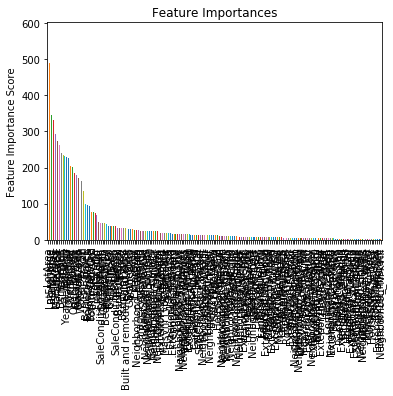

In [261]:
#Set the initial parameters
xgb_y_train = pd.DataFrame(y_train,columns=['target'])
xgb_train = pd.concat([train,xgb_y_train],axis=1)
xgboost = pipes[-3]
xgboost.set_params(**{
    'regressor__learning_rate': 0.1,
    'regressor__n_estimators': 1000, 
    'regressor__max_depth': 5,     
    'regressor__min_child_weight': 1,     
    'regressor__gamma': 0,  
    'regressor__subsample': 0.8,     
    'regressor__colsample_bytree': 0.8,     
    'regressor__objective' : 'reg:linear',     
    'regressor__nthread': 4,
    'regressor__scale_pos_weight': 1,
    'regressor__seed': 2,
})
xgboost = xgboost.get_params()['regressor']
modelfit(xgboost, xgb_train, train.columns)

From here and to the end I will follow the guide, so comments are not needed. The main principle is clear - we want to tune parameters one by one with relatively high learning rate and in the end we want to lower learning rate and find an optimal number of estimators

In [234]:
xgboost.set_params(**{'n_estimators': 355})
param_test_1 = {
    'max_depth': list(range(2,5)),
    'min_child_weight': list(range(1,4))
}
grid_1 = GridSearchCV(xgboost,param_test_1,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)
grid_1.fit(train,y_train)
print(grid_1.best_score_,grid_1.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.7min finished


-0.01414685274340618 {'max_depth': 2, 'min_child_weight': 2}


In [235]:
xgboost.set_params(**grid_1.best_params_)
param_test_2 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
grid_2 = GridSearchCV(xgboost,param_test_2,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)
grid_2.fit(train,y_train)
print(grid_2.best_score_,grid_2.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   43.0s finished


-0.01414685274340618 {'gamma': 0.0}


N_estimators best = 419

Model Report
MSE : 0.005115


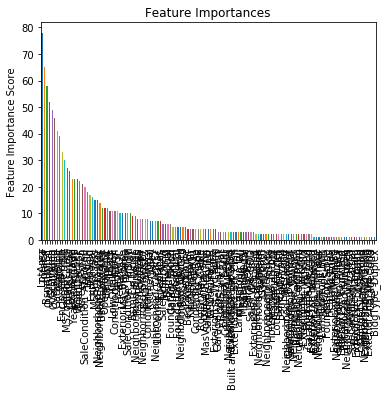

In [237]:
xgboost.set_params(**grid_2.best_params_)
xgboost.set_params(**{'n_estimators': 1000})
modelfit(xgboost, xgb_train, train.columns)


In [243]:
xgboost.set_params(**{'n_estimators': 419})
param_test_3 = {
 'subsample':[i/10.0 for i in range(3,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid_3 = GridSearchCV(xgboost,param_test_3,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)
grid_3.fit(train,y_train)


print(grid_3.best_score_,grid_3.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  4.3min finished


-0.014008713975274336 {'colsample_bytree': 0.6, 'subsample': 0.8}


In [244]:
param_test_3a = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
grid_3a = GridSearchCV(xgboost,param_test_3a,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)
grid_3a.fit(train,y_train)
print(grid_3a.best_score_,grid_3a.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.6min finished


-0.013981214256461679 {'colsample_bytree': 0.6, 'subsample': 0.75}


In [250]:
xgboost.set_params(**grid_3a.best_params_)
param_test4 = {
 'reg_alpha':np.linspace(1e-10,1e-5,10)
}
grid_4 = GridSearchCV(xgboost,param_test4,scoring='neg_mean_squared_error',n_jobs=-1,verbose=2)
grid_4.fit(train,y_train)
print(grid_4.best_score_,grid_4.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.2s finished


-0.013951307640359878 {'reg_alpha': 1e-05}


N_estimators best = 412

Model Report
MSE : 0.005346


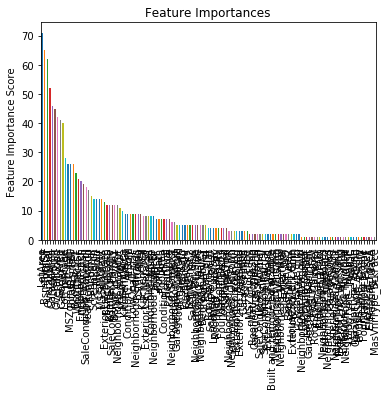

In [256]:
xgboost.set_params(**grid_4.best_params_)
xgboost.set_params(**{'n_estimators': 1000})
modelfit(xgboost, xgb_train, train.columns)

In [269]:
grid_4.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=2, missing=None, n_estimators=2818, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=42, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.75)

N_estimators best = 10000

Model Report
MSE : 0.01065


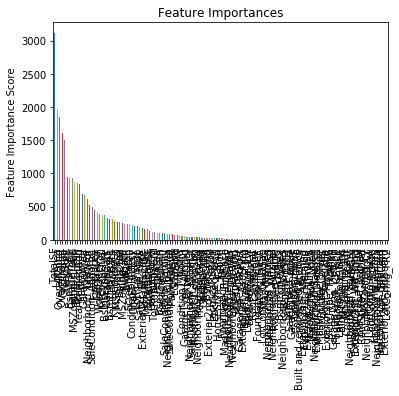

In [266]:
xgboost.set_params(**{'n_estimators': 5000,'learning_rate': 0.01})
modelfit(xgboost, xgb_train, train.columns)

In [271]:
xgboost.set_params(**{'n_estimators': 2818,'learning_rate': 0.01})
xgboost.set_params(**{'n_jobs': -1})


In [291]:
xgb_pars = xgboost.get_params()
xgb_pipe_pars = {}
for ind,item in enumerate(xgb_pars.items()):
    xgb_pipe_pars.update({'regressor__' + item[0]: item[1]})
xgb_pipe_pars

{'regressor__base_score': 0.5,
 'regressor__booster': 'gbtree',
 'regressor__colsample_bylevel': 1,
 'regressor__colsample_bytree': 0.6,
 'regressor__gamma': 0.0,
 'regressor__importance_type': 'gain',
 'regressor__learning_rate': 0.01,
 'regressor__max_delta_step': 0,
 'regressor__max_depth': 2,
 'regressor__min_child_weight': 2,
 'regressor__missing': None,
 'regressor__n_estimators': 2818,
 'regressor__n_jobs': -1,
 'regressor__nthread': 4,
 'regressor__objective': 'reg:linear',
 'regressor__random_state': 42,
 'regressor__reg_alpha': 1e-05,
 'regressor__reg_lambda': 1,
 'regressor__scale_pos_weight': 1,
 'regressor__seed': 2,
 'regressor__silent': True,
 'regressor__subsample': 0.75}

In [8]:
xgb_pipe_pars = {'regressor__base_score': 0.5,
 'regressor__booster': 'gbtree',
 'regressor__colsample_bylevel': 1,
 'regressor__colsample_bytree': 0.6,
 'regressor__gamma': 0.0,
 'regressor__importance_type': 'gain',
 'regressor__learning_rate': 0.01,
 'regressor__max_delta_step': 0,
 'regressor__max_depth': 2,
 'regressor__min_child_weight': 2,
 'regressor__missing': None,
 'regressor__n_estimators': 2818,
 'regressor__n_jobs': -1,
 'regressor__nthread': 4,
 'regressor__objective': 'reg:linear',
 'regressor__random_state': 42,
 'regressor__reg_alpha': 1e-05,
 'regressor__reg_lambda': 1,
 'regressor__scale_pos_weight': 1,
 'regressor__seed': 2,
 'regressor__silent': True,
 'regressor__subsample': 0.75}

## Stacking linear models altogether

Linear models are good, but we want better. In order to achieve this result I decided to use stacking. Stacking is another type of ensemble, where we combine first-level models, train them on our data and pass their predictions to the meta estimator as new input. Of course, there could be more than just two levels, but here we will build relatively simple model.

After some experiments I found the best combination of models and the only thing, which has to be done is to fine-tune the meta-estimator

In [42]:
  estim = [Lasso(alpha=0.0005075949367088608, copy_X=True, fit_intercept=True,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), 
         ElasticNet(alpha=0.0020256410256410257, copy_X=True, fit_intercept=True,
          l1_ratio=0.2158974358974359, max_iter=1000, normalize=False,
          positive=False, precompute=False, random_state=42,
          selection='cyclic', tol=0.0001, warm_start=False), 
         SVR(C=0.00989873417721519, cache_size=200, coef0=0.0, degree=2, epsilon=0.01,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
]
meta = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)
stacked_regression = StackingRegressor(regressors = estim,meta_regressor = meta)
stacked_pipeline = Pipeline([
    ('scaler',RobustScaler()),
    ('regressor',stacked_regression)
])


Iter 1 out of 80 is finished
Iter 2 out of 80 is finished
Iter 3 out of 80 is finished
Iter 4 out of 80 is finished
Iter 5 out of 80 is finished
Iter 6 out of 80 is finished
Iter 7 out of 80 is finished
Iter 8 out of 80 is finished
Iter 9 out of 80 is finished
Iter 10 out of 80 is finished
Iter 11 out of 80 is finished
Iter 12 out of 80 is finished
Iter 13 out of 80 is finished
Iter 14 out of 80 is finished
Iter 15 out of 80 is finished
Iter 16 out of 80 is finished
Iter 17 out of 80 is finished
Iter 18 out of 80 is finished
Iter 19 out of 80 is finished
Iter 20 out of 80 is finished
Iter 21 out of 80 is finished
Iter 22 out of 80 is finished
Iter 23 out of 80 is finished
Iter 24 out of 80 is finished
Iter 25 out of 80 is finished
Iter 26 out of 80 is finished
Iter 27 out of 80 is finished
Iter 28 out of 80 is finished
Iter 29 out of 80 is finished
Iter 30 out of 80 is finished
Iter 31 out of 80 is finished
Iter 32 out of 80 is finished
Iter 33 out of 80 is finished
Iter 34 out of 80 i

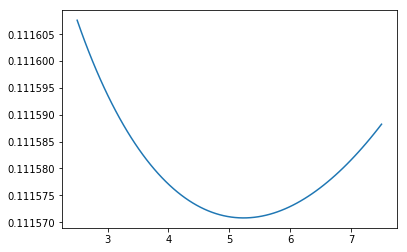

In [43]:
%%time
alphas = np.linspace(2.5,7.5,80,endpoint=True)
res_ = []
for ind,el in enumerate(alphas):
    stacked_pipeline.set_params(**{'regressor__meta_regressor__alpha': el})
    res_.append(rmsle_cv(stacked_pipeline).mean())
    print('Iter %i out of %i is finished' % (ind+1,len(alphas)))
    
plt.plot(alphas,res_)
print(alphas[np.argmin(res_)])

Final model

In [78]:
estim = [Lasso(alpha=0.0005075949367088608, copy_X=True, fit_intercept=True,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), 
         ElasticNet(alpha=0.0020256410256410257, copy_X=True, fit_intercept=True,
          l1_ratio=0.2158974358974359, max_iter=1000, normalize=False,
          positive=False, precompute=False, random_state=42,
          selection='cyclic', tol=0.0001, warm_start=False), 
         SVR(C=0.00989873417721519, cache_size=200, coef0=0.0, degree=2, epsilon=0.01,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
]
meta = Ridge(alpha=5.2215189873417724, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

## Looking at the progress

So, the long and boring part of tuning every model is over and now it's time to look on what we've done so far

### Spoilers from tuning part

In [46]:
xgb_pipe_pars = {'regressor__base_score': 0.5,
 'regressor__booster': 'gbtree',
 'regressor__colsample_bylevel': 1,
 'regressor__colsample_bytree': 0.6,
 'regressor__gamma': 0.0,
 'regressor__importance_type': 'gain',
 'regressor__learning_rate': 0.01,
 'regressor__max_delta_step': 0,
 'regressor__max_depth': 2,
 'regressor__min_child_weight': 2,
 'regressor__missing': None,
 'regressor__n_estimators': 2818,
 'regressor__n_jobs': -1,
 'regressor__nthread': 4,
 'regressor__objective': 'reg:linear',
 'regressor__random_state': 42,
 'regressor__reg_alpha': 1e-05,
 'regressor__reg_lambda': 1,
 'regressor__scale_pos_weight': 1,
 'regressor__seed': 2,
 'regressor__silent': True,
 'regressor__subsample': 0.75}

lgb_pars = {
    'regressor__lambda': 9,
    'regressor__max_depth': 30,
    'regressor__num_leaves': 12,
    'regressor__n_estimators': 175,
    'regressor__subsample': 0.1,
    'regressor__colsample_bytree': 0.21379310344827587,
    'regressor__reg_alpha': 0.2,
}
estim = [Lasso(alpha=0.0005075949367088608, copy_X=True, fit_intercept=True,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), 
         ElasticNet(alpha=0.0020256410256410257, copy_X=True, fit_intercept=True,
          l1_ratio=0.2158974358974359, max_iter=1000, normalize=False,
          positive=False, precompute=False, random_state=42,
          selection='cyclic', tol=0.0001, warm_start=False), 
         SVR(C=0.00989873417721519, cache_size=200, coef0=0.0, degree=2, epsilon=0.01,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
]
meta = Ridge(alpha=5.2215189873417724, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)
stacked_regression = StackingRegressor(regressors = estim,meta_regressor = meta)
stacked_pipeline = Pipeline([
    ('scaler',RobustScaler()),
    ('regressor',stacked_regression)
])


### Recreating pipes

In [49]:
pipes = [
    Pipeline([('scaler',RobustScaler()), ('regressor',Lasso(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',Ridge(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',ElasticNet(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',LinearRegression())]),
    Pipeline([('regressor',SGDRegressor(random_state = 42))]),
    Pipeline([('regressor',RandomForestRegressor(random_state = 42))]),
    Pipeline([('regressor',AdaBoostRegressor(random_state = 42))]),
    Pipeline([('regressor',GradientBoostingRegressor(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',LinearSVR(random_state = 42))]),
    Pipeline([('scaler',RobustScaler()), ('regressor',SVR())]),
    Pipeline([('scaler',RobustScaler()), ('regressor',KNeighborsRegressor())]),
    Pipeline([('regressor',XGBRegressor(random_state = 42))]),
    Pipeline([('regressor',lgb.LGBMRegressor(objective='regression'))]),
    Pipeline([('scaler',RobustScaler()),('regressor',KernelRidge())]),
    Pipeline([('scaler',RobustScaler()),('regressor',stacked_regression)])    
]
cv_pars = [
    #lasso
    {'regressor__alpha': 0.0005075949367088608},
    #ridge
    {'regressor__alpha': 14.949367088607595},
    #elastic
    {'regressor__alpha': 0.0020256410256410257, 'regressor__l1_ratio': 0.2158974358974359},
    #LR
    {},
    #SGD\
    {},
    #RandomForest
    {},
    #AdaBoost
    {'regressor__learning_rate': 0.01, 'regressor__loss': 'linear', 'regressor__n_estimators': 2100},
    #GradientBoosting
    {'regressor__learning_rate': 0.1, 
     'regressor__max_depth': 2.0, 
     'regressor__max_features': 0.25, 
     'regressor__min_samples_leaf': 0.1, 
     'regressor__min_samples_split': 0.4111111111111111,
     'regressor__n_estimators': 1600},
    #LinearSVR
    {'regressor__C': 0.5112658227848101, 'regressor__epsilon': 0},
    #SVR
    {'regressor__C': 0.00989873417721519, 'regressor__epsilon': 0.01, 'regressor__kernel': 'linear'},
    #KNR
    {'regressor__leaf_size': 2, 'regressor__n_neighbors': 4, 'regressor__weights': 'distance'},
    #XGB
    xgb_pipe_pars,
    #LGB
    lgb_pars,
    #KernelRidge
    {'regressor__alpha': 0.01},
    #StackedRegression
    stacked_pipeline.get_params()
]

for ind,pipe in enumerate(pipes):
    pipes[ind] = pipes[ind].set_params(**cv_pars[ind])

The moment of truth!

In [84]:
arr = np.zeros(shape=(len(pipes),3),dtype='object')
for ind,pipe in enumerate(pipes):
    m = re.match("(.+)([.])([A-Za-z0-9-]+)(['>])",str(type(pipe.get_params()['regressor'])))
    score = rmsle_cv(pipe)
    arr[ind] = [m.group(3),score.mean(),score.std()]   
    print("Iter %i out of %i completed" % (ind + 1,len(pipes)))  
    

Iter 1 out of 15 completed
Iter 2 out of 15 completed
Iter 3 out of 15 completed
Iter 4 out of 15 completed
Iter 5 out of 15 completed
Iter 6 out of 15 completed
Iter 7 out of 15 completed
Iter 8 out of 15 completed
Iter 9 out of 15 completed
Iter 10 out of 15 completed
Iter 11 out of 15 completed
Iter 12 out of 15 completed
Iter 13 out of 15 completed
Iter 14 out of 15 completed
Iter 15 out of 15 completed


### Table

As we could see, the progress is actually quite significant. But could we do better?

In [85]:
compare = lambda x: "Tuned" if len(x) > 0 else "Not tuned"
is_tuned = np.array([compare(x) for x in cv_pars])
res_df = pd.DataFrame(index=arr[:,0],columns=['Mean','Std','Is tuned','Id'],
                      data=np.hstack((arr[:,1:],is_tuned.reshape(-1,1),np.arange(len(arr)).reshape(-1,1))))
res_df.sort_values('Mean')

,Mean,Std,Is tuned,Id
StackingRegressor,0.111798,0.00895167,Tuned,14
Lasso,0.11233,0.00798616,Tuned,0
ElasticNet,0.112592,0.00849543,Tuned,2
Ridge,0.113715,0.00949058,Tuned,1
SVR,0.115055,0.010229,Tuned,9
XGBRegressor,0.11632,0.00687493,Tuned,11
LGBMRegressor,0.118399,0.00975277,Tuned,12
LinearRegression,0.129784,0.0115422,Not tuned,3
LinearSVR,0.13183,0.00794201,Tuned,8
GradientBoostingRegressor,0.13269,0.00691605,Tuned,7


The answer is 'yes'! How about little blending on top of our beautiful models, filled with top-class math? Blending is the simple technique of mixing different models predictions. When I tried it, I didn't expect much from it, but suddenly it boosted my performance! My guess is that it worked because of low std of XGB and LGBM, so mixing their predictions with StackedRegression I decreased errors connected to variance. Still, if somebody could explain me why it works like it works - it would be nice.

In [56]:
pipes[14].fit(train,y_train)
pipes[11].fit(train,y_train)
pipes[12].fit(train,y_train)
preds = np.expm1(0.7 * pipes[14].predict(test) + 0.15 * pipes[11].predict(test) + 0.15 * pipes[12].predict(test))
make_submission(preds)

## The end!

Whoooah. That was quite a trip, wasn't it? Thank everybody for reading this kernel. I hope it will help somebody in their work and will be glad to hear some feedback! See ya!